%Porject 15cr (Naeim Rashidfarokhi - Deepthi H Venkataramana)

This code is based on Equations 3 and 10 in Lecture notes nbr.17 by Aaron Clauset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as itt # to generate combinations
import igraph as ig
import random # to uneven split
import copy
import time
from math import comb # to edge finding
from itertools import islice # to uneven split
import statistics

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<font color='green'>Done!</font>"))

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.sparse as sparse
import math

def uneven_split(chunks, mylist)

In [2]:
# https://stackoverflow.com/questions/3589214/generate-random-numbers-summing-to-a-predefined-value
def uneven_split(chunks, mylist):
    #Return a randomly chosen list of n positive integers summing to total

    length = len(mylist)
    dividers = sorted(random.sample(range(1, length), chunks - 1)) 
    
    group_size = [a - b for a, b in zip(dividers + [length], [0] + dividers)]
    
    # https://stackoverflow.com/questions/38861457/splitting-a-list-into-uneven-groups    
    iterator = iter(mylist)
    groups =[list(islice(iterator, 0, i)) for i in group_size]

    groups_dict = {}
    for i in range(len(groups)):
        for j in range(len(groups[i])):
            groups_dict[groups[i][j]] = i
    
    return groups, groups_dict

def print_my_graph(vtxset, edgeset, groups, save, k)

In [3]:
# igraph for visualization
def print_my_graph(vtxset, edgeset, groups, save, k, bipartite, graph_size, my_form):
    
    if (type(groups) is dict):
        # print("DICT CONVERSION!")
        lst = [[] for _ in range(k)]
        for key,value in groups.items():
            lst[value].append(key)
        # print(lst)
        groups = lst
    
    g = ig.Graph()
    g.add_vertices(list(range(len(vtxset))))
    # print(edgeset)
    g.add_edges(edgeset)
    
    colors = list((ig.drawing.colors.known_colors).keys())
    shapes = ['rectangle', 'circle', 'triangle-up', 'triangle-down', 'diamond'] #hidden #null
    
    global my_colors
    my_colors = []
    my_shapes = []
    
    for i in range(k):
        my_colors.append(random.choice(colors))
        my_shapes.append(random.choice(shapes))
    

    # my_colors = ['light green', 'light yellow']
    # print(my_colors, type(my_colors), len(my_colors))
    g.vs["group_nbr"] = 0
    
    # to find related group for each vertex
    for i in range(len(vtxset)):
        for j in range(len(groups)):
            if i in groups[j]:
                g.vs[i]["group_nbr"] = j
    # print(f'my_colors:{my_colors}')
    
    #print(f'edgeset:{edgeset}')
    # https://igraph.org/python/doc/igraph.EdgeSeq-class.html
    my_intra_edges = []
    for i in range(len(groups)):
        temp = g.es.select(_within = groups[i])
        for j in range(len(temp)):
            my_intra_edges.append((temp[j]).tuple)
            
    #print(f'my_intra_edges:{my_intra_edges}')
    
    visual_style = {}
    visual_style["vertex_size"] = 20
    visual_style["vertex_label"] = g.vs["name"]
    visual_style["vertex_color"] = [my_colors[group_nbr] for group_nbr in g.vs["group_nbr"]]
    
    if bipartite:
        print("A bipartite network!")
        g.es["source"] = [e.source for e in g.es]
        # g.es["target"] = [e.target for e in g.es]
        visual_style["vertex_shape"] = [shapes[0] if source in set(g.es["source"]) else shapes[1] for source in list(range(g.vcount()))]
        # [f(x) if condition else g(x) for x in sequence]
        
    else:
        visual_style["vertex_shape"] = [my_shapes[group_nbr] for group_nbr in g.vs["group_nbr"]]
    
    inter_ec, intra_ec = 'Hot Pink', 'black'
    visual_style["edge_color"] = [intra_ec if edge in my_intra_edges else inter_ec for edge in g.get_edgelist()]
    
    visual_style["layout"] = my_form #"kk" # large circular grid_fr
    visual_style["vertex_label_size"] = 9
    visual_style["bbox"] = (graph_size, graph_size)
    
    if save == True:
        visual_style["vertex_label_size"] = 9
        visual_style["vertex_size"] = 15
        visual_style["bbox"] = (graph_size, graph_size)
        ig.plot(g, "SBM.png", **visual_style);
        print(f'A graph with maximum degree:{g.maxdegree()} at vertex/vertices:{g.vs.select(_degree = g.maxdegree())["name"]} saved.')
    else:      
        ig.summary(g)
        
        print(f"Edge colors:\nInter-edges: {inter_ec}\nIntra-edges: {intra_ec}")
        return (ig.plot(g, **visual_style))

edge_prepping_dict(groups, igraph_obj)

In [4]:
# params: splited vertices as 'groups' wtih type dictionary and igraph object as 'igraph_obj'
def edge_prepping_dict(groups, igraph_obj):
    # print(f'groups:{groups}')
    gp_ids = list(set(groups.values())) # to get a unique set of values which are group numbers!
    k = len(gp_ids)
    # print(f'groups:{groups}, gp_ids:{gp_ids}, k:{k}')    
    
    existing_intra = {} # dictionary to save the number of intra edges of each community
    cardinality_each_group = {} # dictionary to save the number of vertices of each community
    possible_intra = {} # dictionary to save the number of possible intra edges of each community
    degree_each_group = {} # dictionary to save the degree of each community
    
    #Intra Edges
    for i in range(len(gp_ids)): # i as index is needed for keys in dictionaries (group identification)
        gp = [k for k,v in groups.items() if v == gp_ids[i]] # one group; to get the keys which are vertices with a value as group id groups.items()[i]
        existing_intra[i] = igraph_obj.subgraph(gp).ecount() #subgraph based on vertices
        #if existing_intra[i] == 0:
            #existing_intra[i] = 1
        
        # cardinality_each_group[i] = igraph_obj.subgraph(gp).vcount()
        cardinality_each_group[i] = sum(value == gp_ids[i] for value in groups.values())
  
        possible_intra[i] = comb(cardinality_each_group[i], 2)
    
        degree_each_group[i] = sum(igraph_obj.degree(gp))
        
    # print(f"existing_intra:{existing_intra}")       
    # print(f"cardinality_each_group:{cardinality_each_group}")
    # print(f"possible_intras:{possible_intra}")
    # print(f"degree_each_group:{degree_each_group}")    
    
    #Inter edges
    possible_inter = {}
    existing_inter = {}
    total_edges_group_pairs = {} # axilary dictionary
    intra_two_groups = {} # axilary dictionary
    
    # https://stackoverflow.com/questions/3294889/iterating-over-dictionaries-using-for-loops
    for i in cardinality_each_group.keys():
        for j in cardinality_each_group.keys():
            if i < j:
                possible_inter[(i,j)] = cardinality_each_group[i] * cardinality_each_group[j] # saving inter edges, key shows group numbers
    
    # print(f"possible_inter:{possible_inter}") 
    
    for i in range(len(gp_ids)):
        for j in range(len(gp_ids)):
            if i < j:
                gp1 = [k for k,v in groups.items() if v == gp_ids[i]]
                gp2 = [k for k,v in groups.items() if v == gp_ids[j]]
                total_edges_group_pairs[(i,j)] = igraph_obj.subgraph(gp1 + gp2).ecount()
                intra_two_groups[(i,j)] = existing_intra[i] + existing_intra[j]
    
    # print(f'total_edges_group_pairs:{total_edges_group_pairs}')
    # print(f'intra_two_groups:{intra_two_groups}')    
     # https://www.datacamp.com/community/tutorials/python-dictionary-comprehension
    existing_inter = {key:(total_edges_group_pairs[key] - intra_two_groups[key]) for (key,value) in zip(total_edges_group_pairs, intra_two_groups)}
    
    # print("total_edges_group_pairs", total_edges_group_pairs)
    # print("intra_two_groups", intra_two_groups) 
    # print("existing_inter", existing_inter)

    # TAKING CARE OF ZERO EXISTING EDGES
    for i in range(len(gp_ids)):
        if possible_intra[i] == 0:
            possible_intra[i] = 1
    
    return existing_intra, existing_inter, possible_intra, possible_inter, degree_each_group, cardinality_each_group

def standard_SBM(intra_exist, inter_exist, intra_nbr_tot, inter_nbr_tot)

In [5]:
### Objective-function: maximum probability likelihood
def standard_SBM(intra_exist, inter_exist, intra_possible, inter_possible):
    
    # print(f'ST_SBM->intra_exist:{intra_exist}')
    # print(f'ST_SBM->inter_exist:{inter_exist}')
    # print(f'ST_SBM->intra_possible:{intra_possible}')
    # print(f'ST_SBM->inter_possible:{inter_possible}')

    #conversion of dictionaries to list
    intra_exist = np.array(list(intra_exist.values()))
    inter_exist = np.array(list(inter_exist.values()))
    intra_possible = np.array(list(intra_possible.values()))
    inter_possible = np.array(list(inter_possible.values()))
    
    k = intra_exist.size # nbr of groups
    
    # SM = np.zeros([k,k]) # stochastic_matrix
    E = np.zeros([k,k]) # Expected edges as intra_exist for diagonal and inter_exist non_diagonal
    N = np.zeros([k,k]) # Possible edges
    
    E[np.diag_indices(k)] = intra_exist # diagonal values
    N[np.diag_indices(k)] = intra_possible # diagonal values
    
    # index production to save inter_exist and inter_exist_total values in correct cells
    itr = 0
    for i in range(k-1):
        for j in range(k):
            if i < j:
                E[i][j] = E[j][i] = inter_exist[itr]
                N[i][j] = N[j][i] = inter_possible[itr]
                itr +=1                  

    # print(f'Expected edges inside and between groups:\n{E}') 
    
    ## CALCULATION PART
    log_mle_value = 0 # Equestion 3, Lecture 17 (Aaron Clauset)    
    for x in range(k):
        for y in range(k):
            if x <= y:
                if (E[x][y] == 0): # case with 0 edges between a pair of groups 0^0 = 1! (SM[i][j])**E[i][j])
                    #log_mle_value += (N[x][y])*np.log(N[x][y])-N[x][y]*np.log(N[x][y]) # E[i][j]*ln(E[i][j])
                    pass
                    #continue
                    
                elif (N[x][y]-E[x][y] == 0): # case with all edges between a pair of groups
                    #log_mle_value += E[x][y]*np.log(E[x][y])-N[x][y]*np.log(N[x][y])
                    pass
                    #continue
                else:
                    log_mle_value += E[x][y]*np.log(E[x][y]) + (N[x][y]-E[x][y])*np.log(N[x][y]-E[x][y])-N[x][y]*np.log(N[x][y])
                    # print(f'E[{x}][{y}]:{E[x][y]}, N[{x}][{y}]:{N[x][y]}, log_mle_value:{log_mle_value}')

    # SM = E/N
    # print(f'E:\n{E}\nN:\n{N}\n') # SM:\n{SM}\n---
    # print(f'ST_MLE:{log_mle_value}')
    return log_mle_value

def degree_corrected_SMB(intra_exist, inter_exist, gp_degree)

In [6]:
def degree_corrected_SMB(intra_exist, inter_exist, gp_degree):
    
    # print(f'DC_SBM->intra_exist:{intra_exist}')
    # print(f'DC_SBM->inter_exist:{inter_exist}')
    # print(f'DC_SBM->gp_degree:{gp_degree}')
    
    # print(f'DC_SBM->intra_exist:{intra_exist}')
    intra_exist = np.array(list(intra_exist.values()))
    inter_exist = np.array(list(inter_exist.values()))
    gp_degree = np.array(list(gp_degree.values()))
        
    k = intra_exist.size # nbr of groups
    # print(f'Number of groups:{k}')
    m = sum(intra_exist) + sum(inter_exist)
    # print(f'All edges in the network:{m}')

    E = np.zeros([k,k]) # As intra_exist for diagonal and inter_exist non_diagonal
    E[np.diag_indices(k)] = intra_exist # diagonal values
    
    # index production to save inter_exist values in correct cells
    itr = 0
    for i in range(k-1):
        for j in range(k):
            if i < j:
                E[i][j] = E[j][i] = inter_exist[itr]
                #print(f'E[{i}][{j}] = E[{j}][{i}] = {inter_exist[itr]}, itr:{itr}')
                itr +=1
    
    # print(f'Total edges(E):\n{E}')
    # print(f'intra_exist:{intra_exist}')
    # print(f'inter_exist:{inter_exist}')    
    D = np.zeros([k,k]) # D for matrix of total degrees in each group
    
    # print(f'gp_degree:{gp_degree}')
    D[np.diag_indices(k)] = gp_degree           
    # print(f'Degree:\n{D}')
    
    ## CALCULATION PART
    m2 = 2 * m
    # print(f'm2:{m2}\n--*--')
    
    dc_mle = 0 #equation 10 from lecture 17
    for x in range(k):
        for y in range(k):
            if (E[x][y] == 0):
                # print(f'2-> i:{i},j{j}:E=0!')
                continue
            else:
                if x == y:
                    p_k = (E[x][y] * 2) / m2
                    dc_mle += p_k * np.log(p_k /((D[x][x]/m2) * (D[y][y]/m2)))
                    # print(f'3-> x:{x},y:{y}, E:{E[x][y]}')
                elif x < y:
                    p_k = E[x][y] / m2
                    dc_mle += p_k * np.log(p_k /((D[x][x]/m2) * (D[y][y]/m2)))
                    # print(f'4-> x:{x},y:{y}, E:{E[x][y]}')
                    
    # print(f'dc_mle:{dc_mle}')
    return dc_mle

best_mle_whereabouts(key, t, intra_exist, inter_exist, intra_possible, inter_possible, gp_degree, gp_cardi, k_communities_dict)

In [7]:
# this function reproduces the graph for the best MLE in a step!
def best_mle_whereabouts(best_change_instep, intra_exist, inter_exist, intra_possible, inter_possible, gp_degree, gp_cardi, k_communities_dict):
    # Six terms needs a copy and an update as below
    
    # print(f'----------------------------------------------------\ninside best_mle_whereabouts\nbest_change_instep:{best_change_instep}')
    key = best_change_instep[0]
    t = best_change_instep[1]
    value = k_communities_dict[key]
    ngbr = graph_obj.neighbors(key)
    
    #print(f'gp_degree[value]:{gp_degree[value]}, graph_obj.degree(key):{graph_obj.degree(key)}')
    gp_degree_temp = gp_degree.copy()
    gp_degree_temp.update({value: gp_degree_temp[value]-graph_obj.degree(key)})
    gp_degree_temp.update({t: gp_degree_temp[t]+graph_obj.degree(key)})

    gp_cardi_temp = gp_cardi.copy()
    gp_cardi_temp.update({value: gp_cardi_temp[value]-1})
    gp_cardi_temp.update({t: gp_cardi_temp[t]+1})

    intra_possible_temp = intra_possible.copy()
    for i in range(len(gp_cardi)):
        intra_possible_temp.update({i: 1 if gp_cardi_temp[i] == 1 else ((gp_cardi_temp[i] * ((gp_cardi_temp[i])-1)) / 2)})
                        
    inter_possible_temp = inter_possible.copy()
    for i in range(len(gp_cardi)):
        for j in range(len(gp_cardi)):
            if i<j: 
                inter_possible_temp.update({(i,j):gp_cardi_temp[i] * gp_cardi_temp[j]})
    
    intra_exist_temp = intra_exist.copy()
    inter_exist_temp = inter_exist.copy()
    for n in ngbr: # n as key for each neighbor
        n_value = k_communities_dict[n] #n_value as group number
    
        #print(f'2-> value:{value}, n_value:{n_value}, t:{t}')
        if t == n_value:
            intra_exist_temp.update({t: intra_exist_temp[t]+1})
            inter_exist_temp.update({tuple(sorted((value, n_value))): inter_exist_temp[tuple(sorted((value, n_value)))]-1})
    
        elif value == n_value:
            intra_exist_temp.update({value: intra_exist_temp[value]-1})
            inter_exist_temp.update({tuple(sorted((t, n_value))): inter_exist_temp[tuple(sorted((t, n_value)))]+1})
    
        else:
            inter_exist_temp.update({tuple(sorted((n_value, t))): inter_exist_temp[tuple(sorted((n_value, t)))]+1})
            inter_exist_temp.update({tuple(sorted((value, n_value))): inter_exist_temp[tuple(sorted((value, n_value)))]-1})
    
    # to update k_communities_dict for next step!
    k_communities_dict_temp = k_communities_dict.copy()
    k_communities_dict_temp.update({key:t})
    
    # print(f'----------------------------------------------------\n')
    return intra_exist_temp, inter_exist_temp, intra_possible_temp, inter_possible_temp, gp_degree_temp, gp_cardi_temp, k_communities_dict_temp

atomic_group(value, gp_cardi)

In [8]:
def atomic_group(value, gp_cardi):
    # k, v is in cardinality dict. If 1 exists in values it means corresponding k in cardinality is 
    # an atomic group. 
    # print(f"value:{value}, gp_cardi:{gp_cardi}")
    for k, v in gp_cardi.items():
        if v == 1:
            if k == value: # Now check if the group of our visiting vertex is that atomic group!
                return True
    return False

def local_heuristic(vtx, edges, k, k_communities, graph_obj, mode, iterations, tolerance)

In [9]:
# param 'itr' is for several-runs with different random initial conditions
def local_heuristic(vtx, edges, k, k_communities_dict, graph_obj, mode, iterations):
    execution_time = time.time()
    
    # validity check for nbr of groups (k)
    nbr_vertices = len(k_communities_dict.keys())
    
    if k > nbr_vertices:
        k = nbr_vertices
        print(f'Selected number of groups exceeds number of vertices. Program continues with {k} vertices for grouping!')
    
    mode = int(mode)
    SBM = ['Standard SBM', 'Degree corrected SBM']
    if (mode != 0) and (mode != 1):
        print (f"Entered mode:{mode}\nSet mode to: 0 -> {SBM[0]} or 1 -> {SBM[1]}")
        return
    else:
        print (f"---\nSelected mode -> {[SBM[0] if mode==0 else SBM[1]]}") 
    
    itr = 0 # counter
    iterations_mle = [] # collection of best communities for iterations
    iterations_community = []
    
    gp_ids = list(set(k_communities_dict.values())) # to get a unique set of values which are group numbers!
    print(f'gp_ids:{gp_ids}')
    
    flag = False # to run the algorithm with first randomized-graph and plot it outside the method
    for iteration in range(iterations): # 3th-FOR (most outer for-loop)
        
        one_move = [False] * len(vtx)
        vertex_watch = dict(zip(vtx, one_move)) # vtx:keys one_move:values changes to True if vtx moves!

        ### Step1: divide the network
        if flag:
            random.shuffle(vtx)
            _, k_communities_dict = uneven_split(k, vtx)
        flag = True

        ### Step2: move one vtx from one community to another
        intra_exist, inter_exist, intra_possible, inter_possible, gp_degree, gp_cardi = edge_prepping_dict(k_communities_dict, graph_obj)

        if mode == 0:
            new_mle = standard_SBM(intra_exist, inter_exist, intra_possible, inter_possible)
        elif mode == 1:
            new_mle = degree_corrected_SMB(intra_exist, inter_exist, gp_degree)

    
        good_move = () # to save that move which leads to best MLE in each step 
        state_mles = [] # to keep the best MLEs of all steps!
        state_mles.append(new_mle)
        state_communities = [] # to keep corresponding communities for best MLEs in state_mles
        state_communities.append(k_communities_dict)
        
        #print(f'k_communities_dict:{k_communities_dict}')
        for key in vertex_watch.keys(): # 2nd-FOR
            #print(f'key1: {key}')
            old_mle = None
            for key, value in k_communities_dict.items(): # 1st-FOR
                if (vertex_watch[key] == True): # subject to the restriction that each vertex may be moved only once
                    #print(f"key2: {key}, Vertex_watch: {vertex_watch[key]}")
                    continue
                if atomic_group(value, gp_cardi):
                    # vertex_watch.update({key: True})
                    # print(f'key2: {key}, Atomic_group!')
                    continue
                #print(f'key2: {key}')
                #print(f'vertex_watch:{vertex_watch}')
                target = copy.deepcopy(gp_ids)
                # print(f'k:{k}, target:{target}, value:{value}')
                target.remove(value)
                ngbr = graph_obj.neighbors(key)
                for t in target:
                    move = (key, t)
                    # Six terms need a copy and an update as below
                    
                    gp_degree_temp = gp_degree.copy()
                    gp_degree_temp.update({value: gp_degree_temp[value]-graph_obj.degree(key)})
                    gp_degree_temp.update({t: gp_degree_temp[t]+graph_obj.degree(key)})

                    gp_cardi_temp = gp_cardi.copy()
                    gp_cardi_temp.update({value: gp_cardi_temp[value]-1})
                    gp_cardi_temp.update({t: gp_cardi_temp[t]+1})

                    intra_possible_temp = intra_possible.copy()
                    for i in range(len(gp_ids)):
                        intra_possible_temp.update({i: 1 if gp_cardi_temp[i] == 1 else ((gp_cardi_temp[i] * ((gp_cardi_temp[i])-1)) / 2)})
                    
                    inter_possible_temp = inter_possible.copy()
                    for i in range(len(gp_ids)):
                        for j in range(len(gp_ids)):
                            if i<j: 
                                inter_possible_temp.update({(i,j):gp_cardi_temp[i] * gp_cardi_temp[j]})
                                
                    intra_exist_temp = intra_exist.copy()
                    inter_exist_temp = inter_exist.copy()

                    for n in ngbr: # n as key for each neighbor
                        n_value = k_communities_dict[n] #n_value as group number

                        if t == n_value:
                            intra_exist_temp.update({t: intra_exist_temp[t]+1})
                            inter_exist_temp.update({tuple(sorted((value, n_value))): (inter_exist_temp[tuple(sorted((value, n_value)))])-1})

                        elif value == n_value:
                            intra_exist_temp.update({value: intra_exist_temp[value]-1})
                            inter_exist_temp.update({tuple(sorted((t, n_value))): inter_exist_temp[tuple(sorted((t, n_value)))]+1})

                        else:
                            inter_exist_temp.update({tuple(sorted((n_value, t))): inter_exist_temp[tuple(sorted((n_value, t)))]+1})
                            inter_exist_temp.update({tuple(sorted((value, n_value))): inter_exist_temp[tuple(sorted((value, n_value)))]-1})

                    if mode == 0:
                        new_mle = standard_SBM(intra_exist_temp, inter_exist_temp, intra_possible_temp, inter_possible_temp) 
                    if mode == 1:
                        new_mle = degree_corrected_SMB(intra_exist_temp, inter_exist_temp, gp_degree_temp)

                    if (old_mle is None) or (new_mle > old_mle):
                        # print(f'new_mle:{new_mle}, old_mle:{old_mle}')
                        old_mle = new_mle
                        good_move = move
                        # print(f'good_move:{good_move}')

            if (old_mle is not None):
                #print(f"--- > good_move:{old_mle}")
                vertex_watch.update({good_move[0]: True})
                #print(f'{vertex_watch}, good_move[0]:{good_move[0]}')
                intra_exist, inter_exist, intra_possible, inter_possible, gp_degree, gp_cardi, k_communities_dict = best_mle_whereabouts(good_move, intra_exist, inter_exist, intra_possible, inter_possible, gp_degree, gp_cardi, k_communities_dict)
                state_communities.append(k_communities_dict)
                state_mles.append(old_mle)
                # print(f'state_mle:{state_mles}')
                # print(f'state_communities:{state_communities}\n')

        state_mles_np = np.array(state_mles)
        state_communities_np = np.array(state_communities)
        
        # mle_accumulated_array = np.add.accumulate(state_mles_np)
        if mode == 0:
            #print(f'state_mles_np:{state_mles_np}')
            #print(f'vertex_watch:{vertex_watch}')
            mle_accumulated_array = state_mles_np[:-1]/state_mles_np[1:]
            # print(f'mle_accumulated_array:{mle_accumulated_array}')
            index = np.argmax(mle_accumulated_array) + 1
        if mode == 1:
            mle_accumulated_array = np.diff(state_mles_np)
            # print(f'mle_accumulatmath.ceil(4.2)ed_array:{mle_accumulated_array}')
            index = np.argmax(mle_accumulated_array) + 1
        
        # print(f'index:{index}')
        
        peak_community = state_communities_np[index] # one structure with best MLE
        peak_community_mle = state_mles_np[index] # one number as the best MLE in one iteration
        # print(f'peak_community:{peak_community}')
        # print(f'peak_community_mle:{peak_community_mle}\n')
        iterations_mle.append(peak_community_mle)
        iterations_community.append(peak_community)
        # print(f'iterations_mle:{iterations_mle}')
        # print(f'iterations_community:{iterations_community}\n')
        
        itr += 1
        if itr % 25 == 0:
            print(f"{itr}", end=" ")
        else:
            print("*", end=" ")
    
    iterations_mle_np = np.array(iterations_mle)
    iterations_community_np = np.array(iterations_community)
    result_index = np.argmax(iterations_mle_np)
    MLE = iterations_mle_np[result_index]
    COMMUNITY = iterations_community_np[result_index]
    
    print(f'\nlog(MLE) value:{MLE}')
    print(f"Execution_time_local_heuristic:{round((time.time() - execution_time), 4)}s after {itr} iterations!")   
    return COMMUNITY, MLE

In [10]:
# raise SystemExit("OK! Stop right here!")

def build_graph(case) #Initial graph generation and plot

In [11]:
def build_graph(case, name, size):
    
    if case == 99:     
        graph_obj = ig.Graph.Read_GML(name) # replace your file name to read it!
        vtx = list(range(graph_obj.vcount()))
        edges = graph_obj.get_edgelist()
        graph_size = (0, 0, size, size)
        color = 'black' # Honeydew Linen
        label = 10
        node_size = 16
        
    else:
        vtx = dict_graph_vtx[case]
        edges = dict_graph_edges[case]
        graph_obj = ig.Graph()
        graph_obj.add_vertices(vtx)
        graph_obj.add_edges(edges)
        graph_size = (0, 0, size, size)
        color = 'black' #'lightblue'
        label = 10
        node_size = 14
        
    # https://en.wikipedia.org/wiki/X11_color_names
    ig.summary(graph_obj)
    return graph_obj, vtx, edges, graph_size, node_size, label, color

def stochastic_BM(k, i_graph, result)

In [12]:
def stochastic_BM(k, i_graph, result):
    print(f"Number of groups:{k}")
    
    lst = [[] for _ in range(k)]
    # print(f'k_communities_dict:{result}')
    for key,value in result.items():
        lst[value].append(key)          
    # print(f'Communities:{lst}')
    
    existing_intra, existing_inter, possible_intra, possible_inter, degree_each_group, cardinality_each_group = edge_prepping_dict(result, i_graph)
    print(f'Degree of groups:{degree_each_group}')
    print(f'Cardinality of groups:{cardinality_each_group}')
    
    existing_intra = np.array(list(existing_intra.values()))
    existing_inter = np.array(list(existing_inter.values()))
    possible_intra = np.array(list(possible_intra.values()))
    possible_inter = np.array(list(possible_inter.values()))
    # -------------------------------------------------- #
    M = np.zeros([k,k]) # stochastic_matrix
    E = np.zeros([k,k]) # Expected edges as intra_exist for diagonal and inter_exist non_diagonal
    N = np.zeros([k,k]) # Possible edges
    
    E[np.diag_indices(k)] = existing_intra # diagonal values
    N[np.diag_indices(k)] = possible_intra # diagonal values
    
    # index production to save inter_exist and inter_exist_total values in correct cells
    itr = 0
    for i in range(k-1):
        for j in range(k):
            if i < j:
                E[i][j] = E[j][i] = existing_inter[itr]
                N[i][j] = N[j][i] = possible_inter[itr]
                itr +=1
    M = E/N
    return M

def print_M(stochastic_matrix, mode, gp_colors)

In [13]:
def print_M(stochastic_matrix, mode, gp_colors):
    
    k = len(stochastic_matrix) 
    fig, ax = plt.subplots()
    # https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html
    #im = ax.imshow(stochastic_matrix, cmap = 'Pastel1')  # 'binary' 'copper'
    
    stochastic_matrix = np.ma.masked_where(stochastic_matrix==0, stochastic_matrix)
    cmap = plt.cm.OrRd
    cmap.set_bad(color='lightgray')
    im = ax.imshow(stochastic_matrix, cmap = cmap)  # 'binary' 'copper'
    
    ax.set_xticks(np.arange(k))
    ax.set_yticks(np.arange(k))
    
    ax.set_xticklabels(gp_colors)
    ax.set_yticklabels(gp_colors)
    
    if k > 3:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(k):
        for j in range(k):
            if stochastic_matrix[i, j] != 'masked':
                value = round(stochastic_matrix[i, j],2)
                text = ax.text(j, i, value, ha="center", va="center", color="k", fontsize=10, weight='bold')
            else:
                value = 0
                text = ax.text(j, i, value, ha="center", va="center", color="k", fontsize=10) # weight='bold'
            
    if mode == 0:
        ax.set_title("Standard Stochastic BLock Matrix\nProbability of existing edge between groups")
    elif mode == 1:
        ax.set_title("Degree Corrected Stochastic BLock Matrix\nProbability of existing edge between groups")  
    # cb = colorbar(label='a label')
    fig.tight_layout()
    plt.show()

Input data!

In [14]:
# Input data!
k = int(input("Enter the nbr of groups:"))
case = int(input("Enter node numbers to run (6, 11, 32, 35 or 99 for gml file):"))

edges6 = np.array([[0,1], [0,2], [1,2], [2,3], [3,4], [3,5], [4,5]])
edges11 = np.array([[0,1], [0,2], [1,2], [10,3], [3,4], [3,5], [4,5],[6,7], [7,3], [6,4], [6,5], [0,9], [3,8], [7,8], [0,3], [4,2], [1,9]])
edges32 = np.array([[0,23],[0,24],[0,28],[0,30],[1,25],[1,26],[1,27],[1,28],[1,29],[1,30],[2,26],[2,28],[2,29],[3,26],[3,28],[3,29],[4,25],[4,26],[4,28],[4,29],[4,30],[5,19],[5,21],[5,22],[5,23],[5,24],[5,25],[5,26],[5,27],[5,28],[5,29],[5,31],[6,15],[6,16],[6,17],[6,19],[6,20],[6,21],[6,22],[6,28],[7,15],[7,16],[7,17],[7,18],[7,19],[7,20],[7,21],[7,22],[7,25],[7,26],[7,27],[7,29],[7,30],[7,31],[8,14], [8, 15], [8, 16], [8, 17],[8, 18], [8, 19], [8, 27], [8, 28], [8, 29], [8, 30],[9, 17], [9, 18], [9, 21],[10, 16], [10, 17], [10, 21],[11, 14], [11, 16], [11, 17], [11, 18], [11, 20], [11, 21],[12, 16], [12, 18], [12, 21],[13, 14], [13, 15], [13, 16], [13, 17], [13, 18], [13, 20]])
edges35 = np.array([[2, 1],[3, 1],[3, 2],[4, 1], [4, 2], [4, 3],[5, 1],[6, 1],[7, 1], [7, 5], [7, 6],[8, 1],[8, 2], [8, 3], [8, 4],[9, 1],[9, 3],[10, 3],[11, 1],[11, 5], [11, 6],[12, 1],[13, 1], [13, 4],[14, 1], [14, 2], [14, 3], [14, 4],[17, 6], [17, 7],[18, 1], [18, 2],[20, 1], [20, 2],[22, 1], [22, 2],[26, 24], [26, 25],[28, 3], [28, 24], [28, 25],[29, 3],[30, 24], [30, 27],[31, 2], [31, 9], [32, 1], [32, 25], [32, 26], [32, 29],[33, 3], [33, 9], [33, 15], [33, 16], [33, 19], [33, 21], [33, 23], [33, 24], [33, 30], [33, 31], [33, 32],[34, 9], [34, 10], [34, 14], [34, 15], [34, 16], [34, 19], [34, 20], [34, 21], [34, 23], [34, 24], [34, 27], [34, 28], [34, 29], [34, 30], [34, 31], [34, 32], [34, 33]])

dict_graph_vtx = {6:[0,1,2,3,4,5], 11:list(range(11)), 32:list(range(32)), 35:list(range(35))}
dict_graph_edges = {6: edges6, 11: edges11, 32: edges32, 35: edges35}

name = "datasets/user_provider.gml"
bipartite = False # True or False <- FOR VERTEX TYPE REPRESENTATION

Enter the nbr of groups:3
Enter node numbers to run (6, 11, 32, 35 or 99 for gml file):11


IGRAPH UN-- 11 17 -- 
+ attr: name (v)


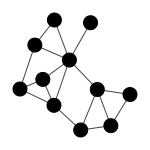

In [15]:
my_graph_size = 150
my_form ='kk' #'large' #'tree' #circle
#check_extra >>>> 
graph_obj, vtx, edges, graph_size, node_size, label, color = build_graph(case, name, my_graph_size)
ig.plot(graph_obj, bbox=graph_size, vertex_color = color, vertex_size = node_size, layout = my_form, vertex_label_size = label)

In [16]:
#raise SystemExit("OK! Stop right here!")

IGRAPH UN-- 11 17 -- 
+ attr: group_nbr (v), name (v)
Edge colors:
Inter-edges: Hot Pink
Intra-edges: black


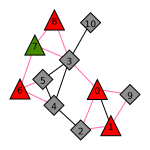

In [17]:
# Initial randomization and plot
random.shuffle(vtx)
k_communities, k_communities_dict = uneven_split(k, vtx)
print_my_graph(vtx, edges, k_communities, False, k, bipartite, my_graph_size, my_form)

STANDARD

In [18]:
result_SE, _ = local_heuristic(vtx, edges, k, k_communities_dict, graph_obj, 0, 100)

---
Selected mode -> ['Standard SBM']
gp_ids:[0, 1, 2]
* * * * * * * * * * * * * * * * * * * * * * * * 25 * * * * * * * * * * * * * * * * * * * * * * * * 50 * * * * * * * * * * * * * * * * * * * * * * * * 75 * * * * * * * * * * * * * * * * * * * * * * * * 100 
log(MLE) value:-19.695881880930543
Execution_time_local_heuristic:2.7962s after 100 iterations!


IGRAPH UN-- 11 17 -- 
+ attr: group_nbr (v), name (v)
Edge colors:
Inter-edges: Hot Pink
Intra-edges: black


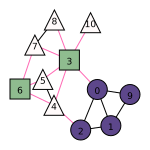

In [19]:
print_my_graph(vtx, edges, result_SE, False, k, bipartite, my_graph_size, my_form)

In [20]:
M_SE = stochastic_BM(k, graph_obj, result_SE)

Number of groups:3
Degree of groups:{0: 13, 1: 9, 2: 12}
Cardinality of groups:{0: 5, 1: 2, 2: 4}


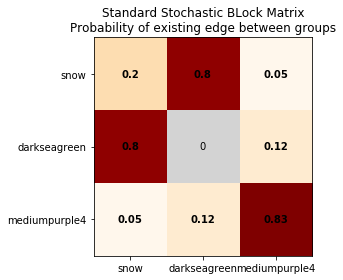

In [21]:
print_M(M_SE, 0, my_colors)
# print(M_SE)

DEGREE CORRECTED

In [22]:
result_DC, _ = local_heuristic(vtx, edges, k, k_communities_dict, graph_obj, 1, 100)

---
Selected mode -> ['Degree corrected SBM']
gp_ids:[0, 1, 2]
* * * * * * * * * * * * * * * * * * * * * * * * 25 * * * * * * * * * * * * * * * * * * * * * * * * 50 * * * * * * * * * * * * * * * * * * * * * * * * 75 * * * * * * * * * * * * * * * * * * * * * * * * 100 
log(MLE) value:0.43425856998881585
Execution_time_local_heuristic:1.9821s after 100 iterations!


In [23]:
M_DC = stochastic_BM(k, graph_obj, result_DC)

Number of groups:3
Degree of groups:{0: 12, 1: 10, 2: 12}
Cardinality of groups:{0: 4, 1: 3, 2: 4}


IGRAPH UN-- 11 17 -- 
+ attr: group_nbr (v), name (v)
Edge colors:
Inter-edges: Hot Pink
Intra-edges: black


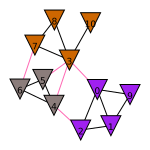

In [24]:
print_my_graph(vtx, edges, result_DC, False, k, bipartite, my_graph_size, my_form)

In [25]:
# raise SystemExit("OK! Stop right here!")

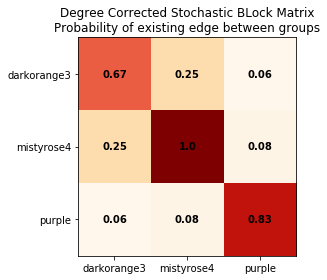

In [26]:
print_M(M_DC, 1, my_colors)
# print(M_DC)

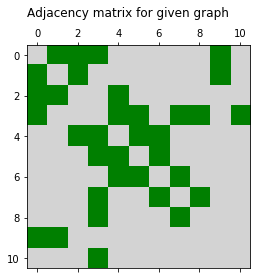

In [27]:
#Adjacency matrix
adj_mtx = np.array(list(graph_obj.get_adjacency()))
cmap = ListedColormap(['lightgray', 'g'])
plt.matshow(adj_mtx, cmap=cmap)
plt.title('Adjacency matrix for given graph', loc='left',  y=1.1)
plt.show()

In [28]:
clustering_coeff = graph_obj.transitivity_undirected()
print(f'Clustering_coeffecient: {clustering_coeff}')

assort_deg = graph_obj.assortativity_degree()
print(f'Degree assortativity: {assort_deg}')

Clustering_coeffecient: 0.3409090909090909
Degree assortativity: -0.33939393939393997


In [29]:
# raise SystemExit("OK! Stop right here!")

In [30]:
def strictly_convex_k(graph):
    #E = total number of edges; N = total number of vertices
    E = graph.ecount()
    N = graph.vcount()
    print(f'E:{E}, N:{N}')
    
    sigma_k_values = {}
    for k in range(2, N-1):  # k is the number of communities
        m = k*k + k
        x = (m)/(2*E)
        h = (1+x)*(np.log(1+x)) - (x)*(np.log(x))
        sigma_k = E*h - (E-N)*(np.log(k))
        sigma_k_values.update({k:sigma_k})
        
    #print(f'sigma_k_values:{sigma_k_values}')
    
    optimal_k = min(sigma_k_values.keys(), key=(lambda k: sigma_k_values[k]))
    print(f'optimal_k: {optimal_k}')
    
    data = sorted(sigma_k_values.items()) # sorted by key, return a list of tuples
    x, y = zip(*data) # unpack a list of pairs into two tuples
    plt.grid()
    plt.plot(x, y)
    plt.ylabel(r'$\sigma_k$', size=16)
    plt.xlabel('Number of communities(k)', size=12)
    plt.title(f'Optimum community numbers\nwith Minimum Description Length Principle: {optimal_k}')
    plt.plot(optimal_k, sigma_k_values[optimal_k], 'rx', markersize=8)
    plt.show()
    
    return optimal_k

E:17, N:11
optimal_k: 2


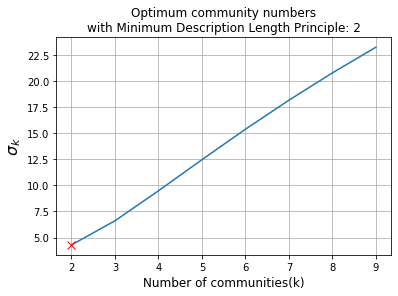

In [31]:
optimal_k = strictly_convex_k(graph_obj)

In [32]:
# A function to find necessary iterations for a given constant grouping (k)
def find_best_iteration(k, vtx, edges, graph_obj, mode, default, max_itr, interval):
    itrs = list(range(default, max_itr + interval, interval))
    print(f"Iterations to test:{itrs}")
    
    mle_itr_dict = {}
    for itr in itrs:
        _, k_communities_dict = uneven_split(k, vtx)
        _, result = local_heuristic(vtx, edges, k, k_communities_dict, graph_obj, mode, itr)
        mle_itr_dict.update({itr: result})
    
    max_mle = max(mle_itr_dict.values())
    best_itr = [k for k, v in mle_itr_dict.items() if v == max_mle]
    print(f'LOOK -> max_mle:{max_mle} happens with best_itr:{best_itr}')
    
    mles = np.array(list(mle_itr_dict.values()))
    plt.plot(itrs, mles, '-bo')
    plt.ylabel('log(MLE)')
    plt.xlabel('Number of iterations')
    plt.title(f'Best MLE result with k={k} and {best_itr[0]} iterations')
    plt.title(f'MLE results for different iterations for k:{k}')
    plt.grid()
    
    return best_itr

In [33]:
# best_itr = find_best_iteration(optimal_k, vtx, edges, graph_obj, 1, 50, 200, 50)

In [34]:
# A comparative function; example -> 1000 iterations or 10 simulations with 100 iterations!? 100x10 vs 1000
def use_iterations_wisely(vtx, edges, k, graph_obj, mode, base_itr, nbr_simulations):
    print(f"Comparative check for {base_itr}x{nbr_simulations} simulations vs 1x{base_itr*nbr_simulations} simulation!")
    
    # CASE 1: nbr_simulations such as 10 with 'base_itr' such as 100
    mle_itr_dict = {}
    for i in range(nbr_simulations):
        _, k_communities_dict = uneven_split(k, vtx)
        _, result = local_heuristic(vtx, edges, k, k_communities_dict, graph_obj, mode, base_itr)
        mle_itr_dict.update({(i+1): result})
    
    mle_itr_np = np.array(list(mle_itr_dict.values()))
    plt.plot(list(range(nbr_simulations)), mle_itr_np, '-go')
    plt.title(f'Results for k={k}, {base_itr}x{nbr_simulations} simulations vs 1x{base_itr*nbr_simulations} simulation')
    plt.ylabel('log(MLE)')
    plt.xlabel('Simulation numbers')
    plt.grid()
    
    index_M = np.argmax(mle_itr_np)
    mle_A_M = mle_itr_np[index_M]
    index_m = np.argmin(mle_itr_np)
    mle_A_m = mle_itr_np[index_m]
    
    # CASE 2: one simulation with 'itrs' iterations such as 1000
    _, k_communities_dict = uneven_split(k, vtx)
    _, mle_B = local_heuristic(vtx, edges, k, k_communities_dict, graph_obj, mode, base_itr*nbr_simulations)
    plt.plot(nbr_simulations-1, mle_B, 'rx', markersize=10)
    print("-------")
    print(f"RESULT:\nWith 1 simulation and {base_itr*nbr_simulations} of iterations:{mle_B}\nWith {nbr_simulations} simulations and {base_itr} of iterations:\nMax:{mle_A_M}\nmin:{mle_A_m}\nDifference:{mle_A_M-mle_A_m}")
    
    return 'Insight!'

In [35]:
# use_iterations_wisely(vtx, edges, optimal_k, graph_obj, 1, 10, 10)

In [36]:
# A function to find necessary iterations and number of runs
def optimized_iteration(k, vtx, edges, graph_obj, mode, default, max_itr, interval, runs):
    itrs = list(range(default, max_itr + interval, interval))
    print(f"Iterations to test:{itrs}")
    
    mle_itr_dict = {}
    comm_itr_dict = {}
    for itr in itrs:
        mle_list = []
        comm_list = []
        for run in range(runs):
            _, k_communities_dict = uneven_split(k, vtx)
            community, mle = local_heuristic(vtx, edges, k, k_communities_dict, graph_obj, mode, itr)
            mle_list.append(mle)
            comm_list.append(community)
        mle_itr_dict.update({itr: mle_list})
        comm_itr_dict.update({itr: comm_list})
    
    # print(f'>>>>>>>>> mle_itr_dict:{mle_itr_dict}')
    # print(f'>>>>>>>>> comm_itr_dict:{comm_itr_dict}')
    
    # min_max_mean_mle = {}
    max_mle_dict = {}
    mean_values = []
    error_range = []
    for key, value in mle_itr_dict.items():
        minimum = min(value)
        maximum = max(value)
        mean = statistics.mean(value)
        # min_max_mean_mle.update({key: [minimum, maximum, mean]})
        max_mle_dict.update({key: [maximum]})
        error_range.append((maximum-minimum)/2)
        mean_values.append(mean)
    
    # print(f'>>>>>>>>> max_mle_dict:{max_mle_dict}')
    
    max_mle = max(max_mle_dict.values())
    best_key = [k for k, v in max_mle_dict.items() if v == max_mle]
    print(f'Maximum MLE:{max_mle} happens with best_itr:{best_key}')
    
    # print(F'AAAAAAAAAA:{mle_itr_dict[best_key[0]]}')
    target_comm = mle_itr_dict[best_key[0]]
    max_index = target_comm.index(max_mle)
    
    # print(f'>>>>>> max_index:{max_index}')
    # print(f'RESULT: {(comm_itr_dict[best_key[0]])[max_index]}')
    
    
    f = plt.figure(figsize=(9,4))
    mles = np.array(list(mle_itr_dict.values()))
    ax = f.add_subplot(121)
    ax.plot(itrs, mles, 'o', color='black')
    plt.ylabel('log(MLE)')
    plt.xlabel('Number of iterations')
    plt.title(f'Best MLE result with k={k} and {best_key[0]} iterations')
    plt.title(f'MLE results for {runs} runs and k:{k}')
    plt.grid()
    
    ax2 = f.add_subplot(122)
    ax2.errorbar(itrs, mean_values, yerr=error_range, ecolor='blue', fmt='kx', markersize= 8, linestyle='--', capsize=4) # uplims=True,lolims=True
    plt.xlabel('Number of iterations')
    plt.title(f'min-mean-MAX MLE values for {runs} runs')
    plt.grid()
    
    return (comm_itr_dict[best_key[0]])[max_index]

Iterations to test:[25, 50, 75, 100]
---
Selected mode -> ['Degree corrected SBM']
gp_ids:[0, 1]
* * * * * * * * * * * * * * * * * * * * * * * * 25 
log(MLE) value:0.3728999474550605
Execution_time_local_heuristic:0.2242s after 25 iterations!
---
Selected mode -> ['Degree corrected SBM']
gp_ids:[0, 1]
* * * * * * * * * * * * * * * * * * * * * * * * 25 
log(MLE) value:0.3728999474550605
Execution_time_local_heuristic:0.2344s after 25 iterations!
---
Selected mode -> ['Degree corrected SBM']
gp_ids:[0, 1]
* * * * * * * * * * * * * * * * * * * * * * * * 25 
log(MLE) value:0.3728999474550605
Execution_time_local_heuristic:0.2172s after 25 iterations!
---
Selected mode -> ['Degree corrected SBM']
gp_ids:[0, 1]
* * * * * * * * * * * * * * * * * * * * * * * * 25 
log(MLE) value:0.3728999474550605
Execution_time_local_heuristic:0.2285s after 25 iterations!
---
Selected mode -> ['Degree corrected SBM']
gp_ids:[0, 1]
* * * * * * * * * * * * * * * * * * * * * * * * 25 
log(MLE) value:0.3728999474

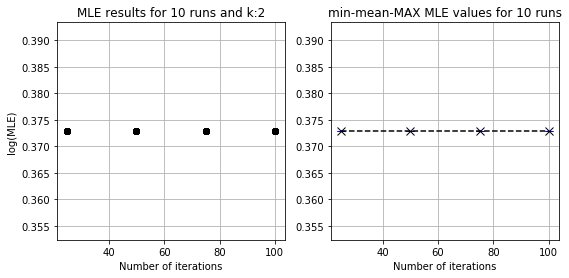

In [37]:
start_time = time.time()
result_DC2 = optimized_iteration(optimal_k, vtx, edges, graph_obj, 1, 25, 100, 25, 10)
print(f'Total optimized_iteration time:{time.time() - start_time} seconds!')

IGRAPH UN-- 11 17 -- 
+ attr: group_nbr (v), name (v)
Edge colors:
Inter-edges: Hot Pink
Intra-edges: black


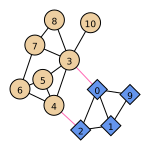

In [92]:
print_my_graph(vtx, edges, result_DC2, False, optimal_k, bipartite, my_graph_size, my_form)

Number of groups:2
Degree of groups:{0: 22, 1: 12}
Cardinality of groups:{0: 7, 1: 4}


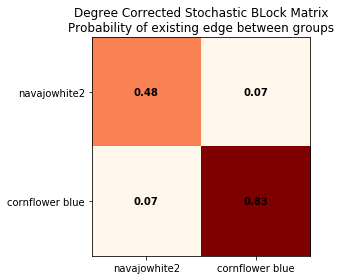

In [93]:
M_DC2 = stochastic_BM(optimal_k, graph_obj, result_DC2)
print_M(M_DC2, 1, my_colors)